# Online Retail数据集

## 1.分析目的
根据RFM对客户进行细分，以便公司能够有效地锁定有价值的客户

## 数据集来源
https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [4]:
dataset = pd.read_csv("D:/github项目/数据集/OnlineRetail.csv", sep=",", encoding="ISO-8859-1", header=0)
print ('数据集:',dataset.shape) 

数据集: (541909, 8)


#### 在线零售是一个跨国数据集，有541909条数据，8个字段,包含2010年12月1日至2011年12月9日期间英国注册的非商店在线零售的所有交易。

#### 该公司主要销售独特的各种场合礼品。这家公司的许多客户都是批发商。

## 2.理解数据

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
dataset.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


### 字段解释

1‌.`InvoiceNo`（发票编号）‌: 每笔交易/订单的唯一标识符
‌

2.`StockCode`（商品代码）‌：商品的唯一编码标识


‌3.`Description`（商品描述‌）：商品的文字描述信息


4‌.`Quantity`（数量）：交易中该商品的数量


5‌.`InvoiceDate`（发票日期）‌：交易发生的日期时间


6‌.`UnitPrice`（单价）‌：单个商品的价格（单位通常是当地货币）


7‌.`CustomerID`（客户ID）‌：客户的唯一标识符


‌8.`Country`（国家）‌：客户所在国家/地区

## 3.数据预处理

In [7]:
#查缺失值
print ('缺失值数量:\n',dataset.isnull().sum())
print(" ")
print ('缺失值占比:\n',dataset.isnull().sum()/dataset.shape[0])

缺失值数量:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
 
缺失值占比:
 InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64


In [8]:
# 删除缺失值
dataset = dataset.dropna()
dataset.shape

(406829, 8)

In [12]:
# 转换成字符串
dataset['CustomerID'] = dataset['CustomerID'].astype(str)

## 4.数据分析

### RFM模型构建

通过RFM模型衡量客户价值，找到最具价值的客户群，以对不同类型的客户进行差异化营销，进而提高企业收益。

RFM模型包含三个分析要素，分别为：

1.`R(Recency)`:最近一次购买距离现在的时间，值越小价值越大

2.`F(Frequency)`:某段时间购买次数，越大越好

3.`M(Monetary)`:某段时间的购买总金额，越大越好

In [14]:
# 总金额计算
dataset['Amount'] = dataset['Quantity']*dataset['UnitPrice']

In [15]:
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [16]:
max_date = max(dataset['InvoiceDate'])

In [18]:
rfm = dataset.groupby('CustomerID').agg(
    recency=('InvoiceDate', lambda x: (max_date - x.max()).days),
    frequency=('InvoiceNo', 'nunique'),
    monetary=('Amount', 'sum')
)

rfm

,recency,frequency,monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,3,176.60


### RFM模型的评分转换和均值计算

In [19]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm["r"] = rfm["recency_score"].astype(int)
rfm["f"] = rfm["frequency_score"].astype(int)
rfm["m"] = rfm["monetary_score"].astype(int)
r_mean =rfm["r"].mean()
f_mean =rfm["f"].mean()
m_mean =rfm["m"].mean()

In [20]:
#计算价值的平均值，指标得分高于平均值标记为高，反之标记为低
def r(x):
    if x["r"]>r_mean:
        return 1 
    else:
        return 0 

def f(x):
    if x["f"]>r_mean:
        return 1 
    else:
        return 0 

def m(x):
    if x["m"]>r_mean:
        return 1 
    else:
        return 0
rfm["r"] = rfm.apply(r,axis=1)
rfm["f"] = rfm.apply(f,axis=1)
rfm["m"] = rfm.apply(m,axis=1)

In [21]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,r,f,m
CustomerID,,,,,,,,,
12346.0,325,2,0.00,1,2,1,0,0,0
12347.0,1,7,4310.00,5,4,5,1,1,1
12348.0,74,4,1797.24,2,3,4,0,0,1
12349.0,18,1,1757.55,4,1,4,1,0,1
12350.0,309,1,334.40,1,1,2,0,0,0


<img src="./rfm.jpg" >

In [23]:
# 客户分层如下，1为高，0为低
rfm["rfm"]=rfm["r"].astype(str) + rfm["f"].astype(str) + rfm["m"].astype(str)
def rfm_model(x):
    if x == "111":
        return "重要价值客户"
    elif x == "101":
        return "重要发展客户"
    elif x == "011":
        return "重要保持客户"
    elif x == "001":
        return "重要挽留客户"
    elif x == "110":
        return "一般价值客户"
    elif x == "100":
        return "一般发展客户"
    elif x == "010":
        return "一般保持客户"
    elif x == "000":
        return "一般挽留客户"  
rfm["rfm_model"] = rfm["rfm"].apply(rfm_model)
rfm["rfm_model"].value_counts()

rfm_model
一般挽留客户    1744
重要价值客户     976
一般发展客户     526
重要保持客户     420
重要挽留客户     243
一般保持客户     185
一般价值客户     168
重要发展客户     110
Name: count, dtype: int64

In [24]:
rfm_new = rfm["rfm_model"].value_counts().to_frame().reset_index()
rfm_new.columns = ["customer_type","num"]

In [41]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统使用黑体
# plt.rcParams['font.sans-serif'] = ['Heiti TC']  # Mac系统使用黑体-简
# plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # Linux系统使用文泉驿微米黑

# 解决负号('-')显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

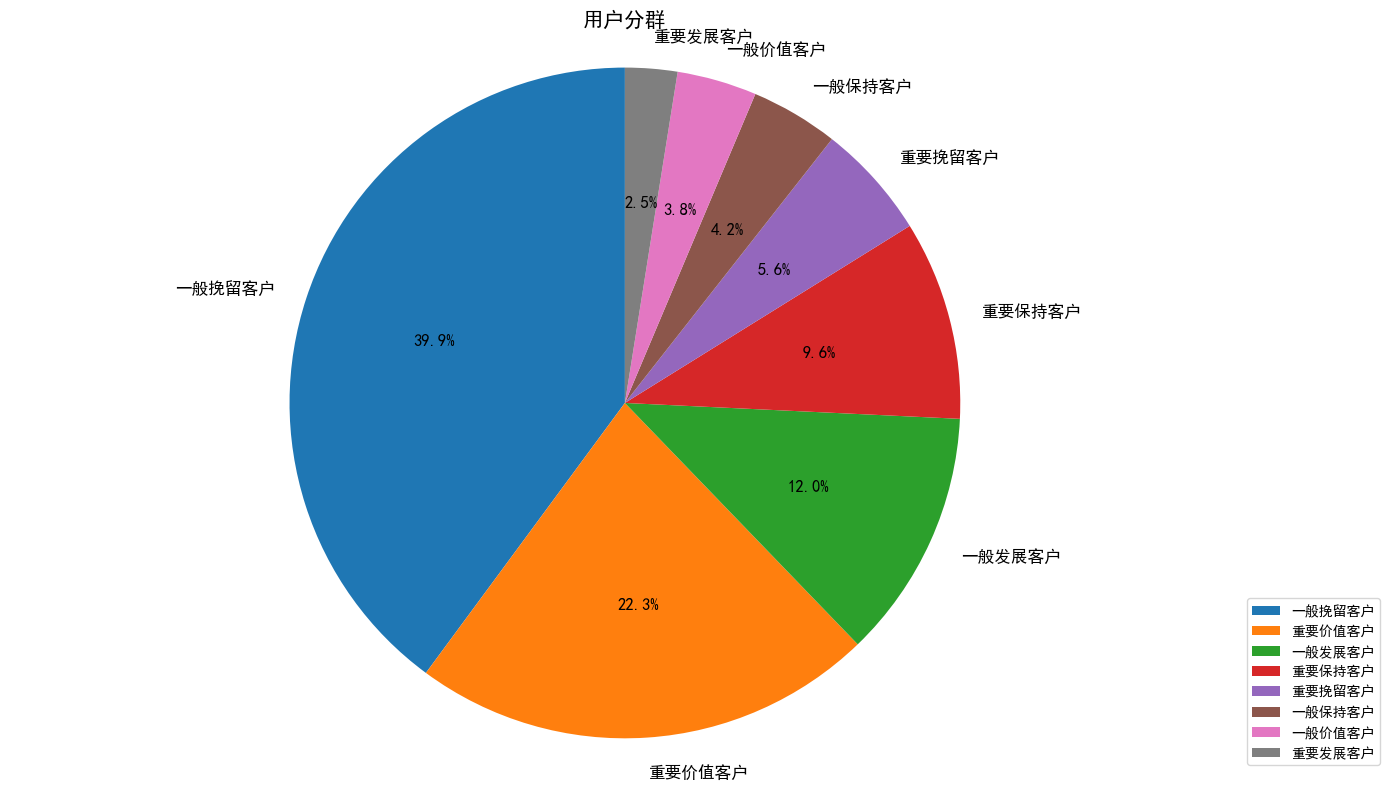

In [35]:
labels = rfm_new["customer_type"].tolist()
sizes = rfm_new["num"].tolist()

# 创建饼图
plt.figure(figsize=(14, 8))
plt.pie(sizes, 
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12})

# 设置标题和图例
plt.title("用户分群", fontsize=15)
plt.legend(labels, 
           loc="lower left",
           bbox_to_anchor=(1, 0, 0.5, 1))

# 显示图形
plt.axis('equal')  # 保证饼图是圆形
plt.tight_layout()
plt.show()

In [44]:
from matplotlib import font_manager as fm
import matplotlib as mpl

# 加载指定字体文件
try:
    # 查找字体文件路径 - 如果simhei.ttf在当前目录
    font_path = 'simfang.ttf'
    
    # 如果不在当前目录，请替换为你的实际路径
    # font_path = 'full/path/to/your/simhei.ttf'
    
    # 注册字体
    font_prop = fm.FontProperties(fname=font_path)
    font_name = font_prop.get_name()
    
    # 设置全局字体
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    print(f"成功加载字体: {font_name}")
except Exception as e:
    print(f"加载字体失败: {e}")
    # 失败时使用默认字体
    plt.rcParams['font.family'] = ['sans-serif']

成功加载字体: FangSong


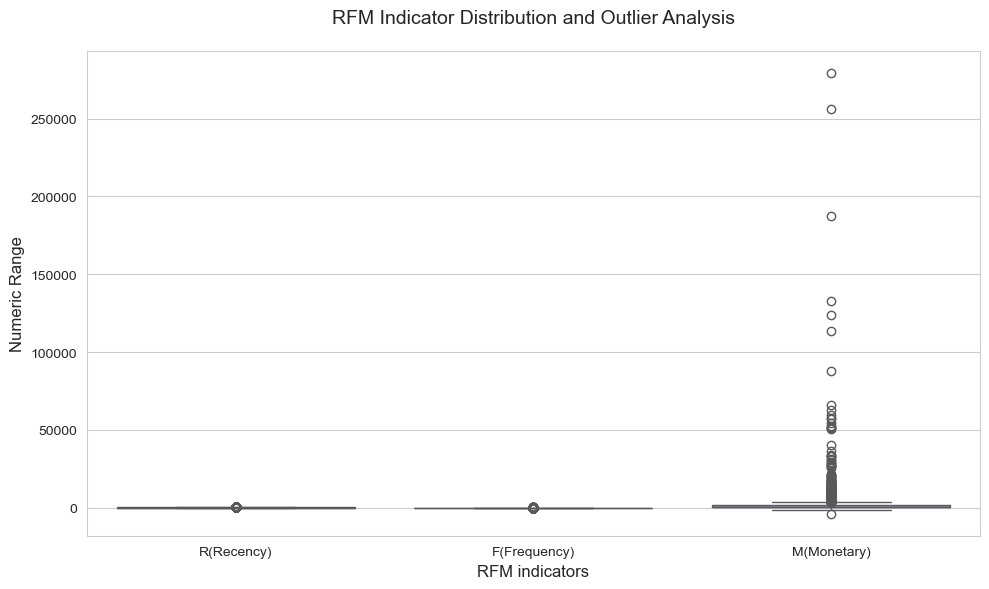

In [46]:
# 设置图形样式
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# 绘制箱线图
sns.boxplot(data=rfm[['recency', 'frequency', 'monetary']], 
            orient="v",
            palette="Set2",
            whis=1.5)

# 添加图表标注
plt.title("RFM Indicator Distribution and Outlier Analysis", fontsize=14, pad=20)
plt.xlabel("RFM indicators", fontsize=12)
plt.ylabel("Numeric Range", fontsize=12)
plt.xticks([0, 1, 2], 
           ['R(Recency)', 'F(Frequency)', 'M(Monetary)'])

# 调整布局并显示
plt.tight_layout()
plt.show()


### K-means

#### K-means聚类是最简单、最流行的无监督机器学习算法之一。

#### 该算法的工作原理如下：
1.特征选择和特征提取

2.数据对象间相似度计算

3.根据相似度将数据对象分组

In [54]:
df_clustering = rfm[["recency","frequency","monetary"]]
#特征缩放
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled,columns=['recency', 'frequency', 'monetary'])
df_scaled["CustomerID"] = df_clustering.index


In [55]:
df_scaled = df_scaled.set_index("CustomerID",drop=True)
df_scaled

,recency,frequency,monetary
CustomerID,,,
12346.0,2.322023,-0.329362,-0.231001
12347.0,-0.893733,0.206102,0.293432
12348.0,-0.169196,-0.115176,-0.012316
12349.0,-0.725005,-0.436455,-0.017146
12350.0,2.163220,-0.436455,-0.190312
...,...,...,...
18280.0,1.845615,-0.436455,-0.209026
18281.0,0.882873,-0.436455,-0.221167
18282.0,-0.834182,-0.222269,-0.209513


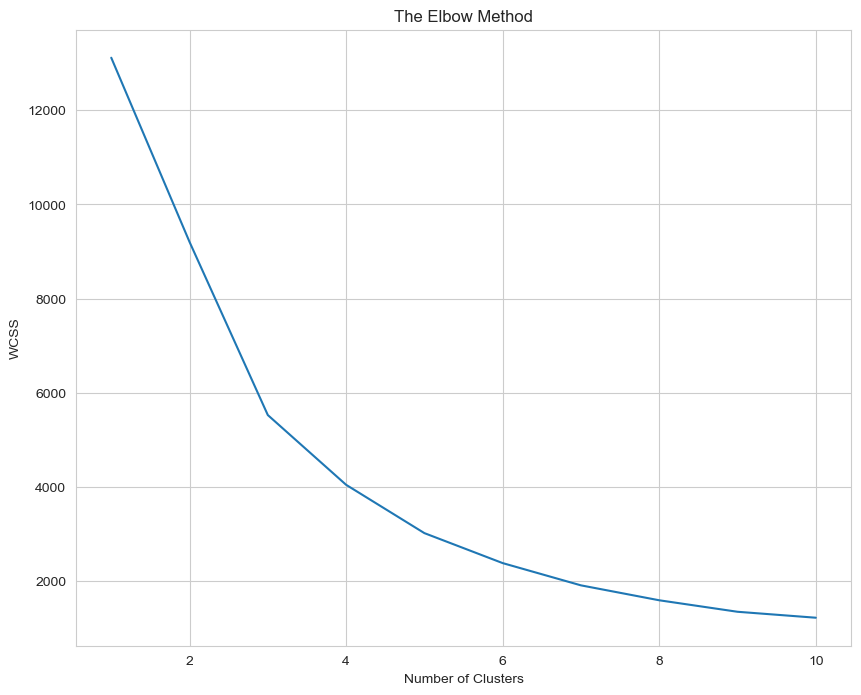

In [56]:
#Kmeans算法
from sklearn.cluster import KMeans
X = df_scaled.values
#手肘法则
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [57]:
kmeans = KMeans(n_clusters=4, n_init = 15, random_state=1)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df

,recency,frequency,monetary
0,-0.500632,-0.029238,-0.051098
1,-0.837491,8.987721,21.936558
2,-0.822452,3.812213,2.012982
3,1.547375,-0.350150,-0.175821


In [58]:
df_kmeans = df_clustering.copy()
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')
df_kmeans['labels'] = df_labels['labels'].values
df_kmeans


,recency,frequency,monetary,labels
CustomerID,,,,
12346.0,325,2,0.00,3
12347.0,1,7,4310.00,0
12348.0,74,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,309,1,334.40,3
...,...,...,...,...
18280.0,277,1,180.60,3
18281.0,180,1,80.82,3
18282.0,7,3,176.60,0


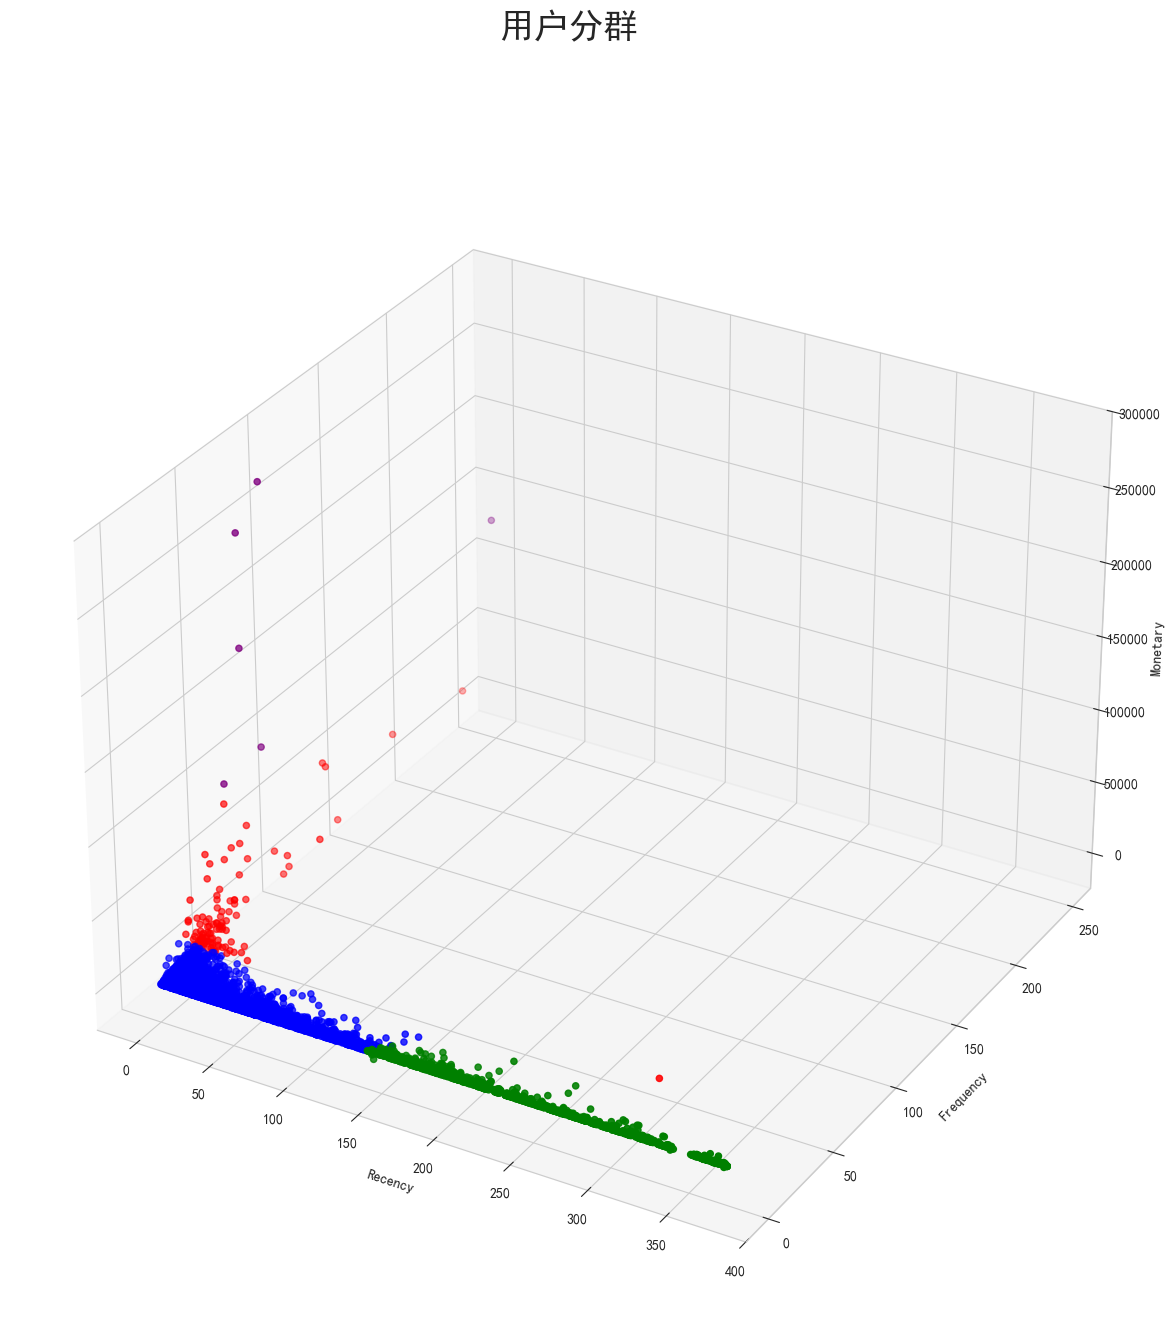

In [60]:
%matplotlib inline
# 设置matplotlib的字体参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
colors = np.array(["blue", "purple","red","green"])
fig  = plt.figure(figsize = (15,15)).suptitle('用户分群', fontsize=25)
ax = plt.axes(projection='3d')
ax.scatter3D(df_kmeans["recency"], df_kmeans["frequency"], df_kmeans["monetary"], marker='o', c=colors[df_kmeans["labels"].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
#plt.legend()
plt.show()

In [61]:
df_kmeans = df_kmeans.reset_index()
clusters_count = df_kmeans.groupby("labels").agg({"CustomerID": "count"})#不同分组用户数量
clusters_count

C:\Users\27164\AppData\Local\Temp\ipykernel_10952\2787818087.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clusters_count = df_kmeans.groupby("labels").agg({"CustomerID": "count"})#不同分组用户数量


,CustomerID
labels,
0,3169
1,6
2,110
3,1087


C:\Users\27164\AppData\Local\Temp\ipykernel_10952\1587491244.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=clusters_count,x=clusters_count["cluster"],y=clusters_count["count"], palette='coolwarm')


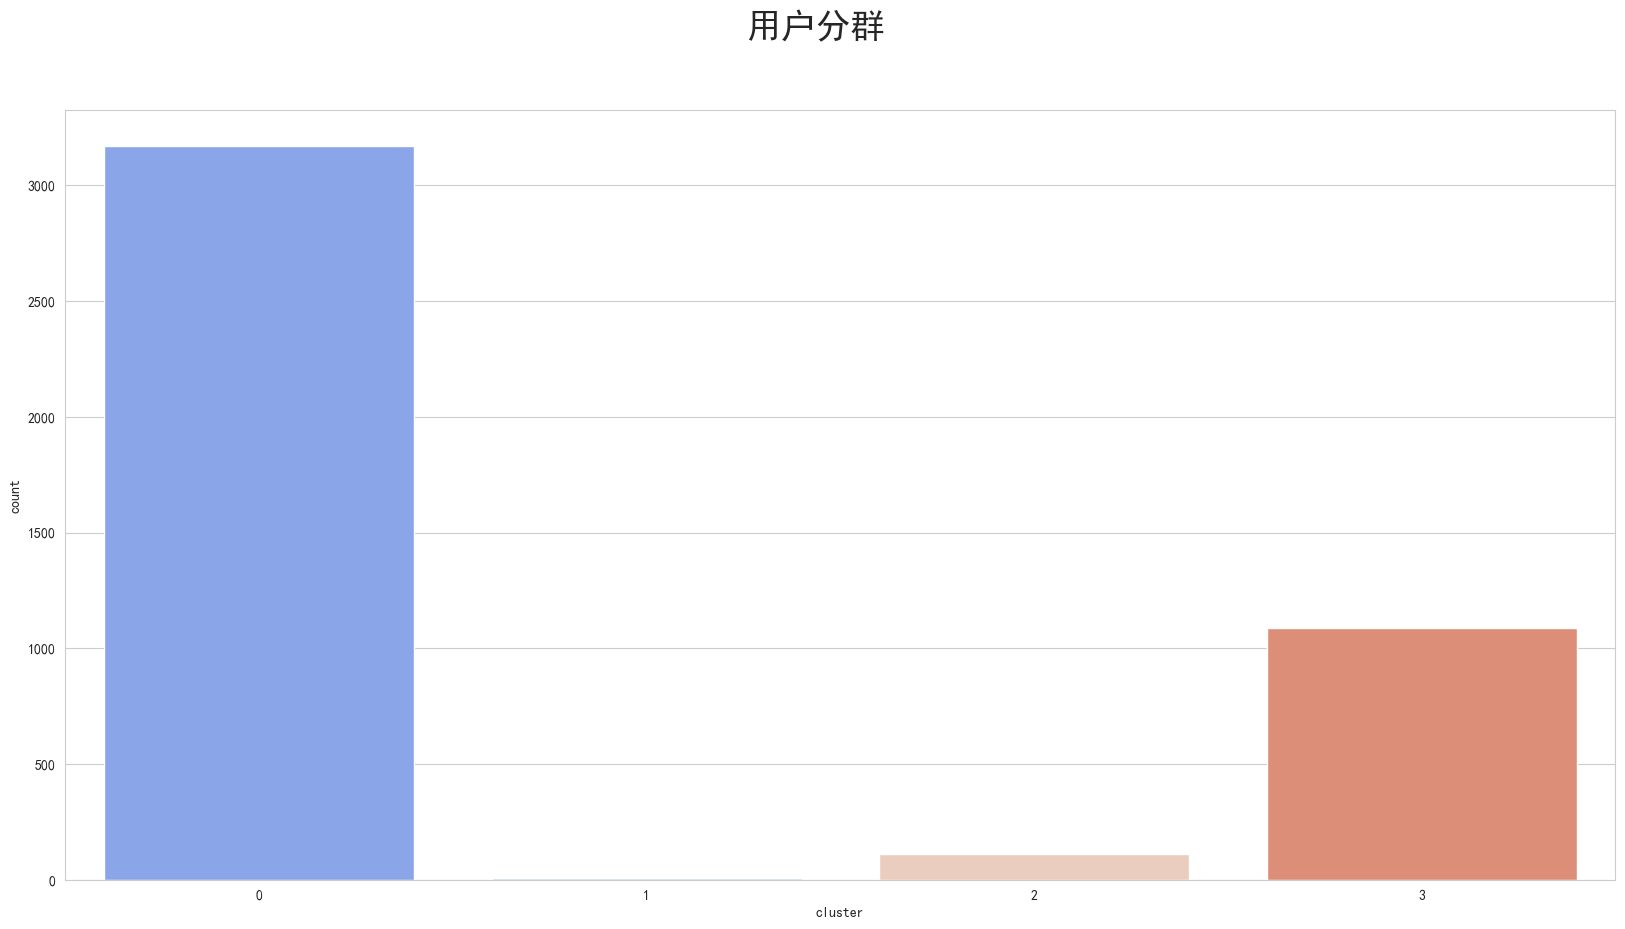

In [62]:
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']
fig  = plt.figure(figsize = (20,10)).suptitle('用户分群', fontsize=25)
sns.barplot(data=clusters_count,x=clusters_count["cluster"],y=clusters_count["count"], palette='coolwarm')

plt.show()

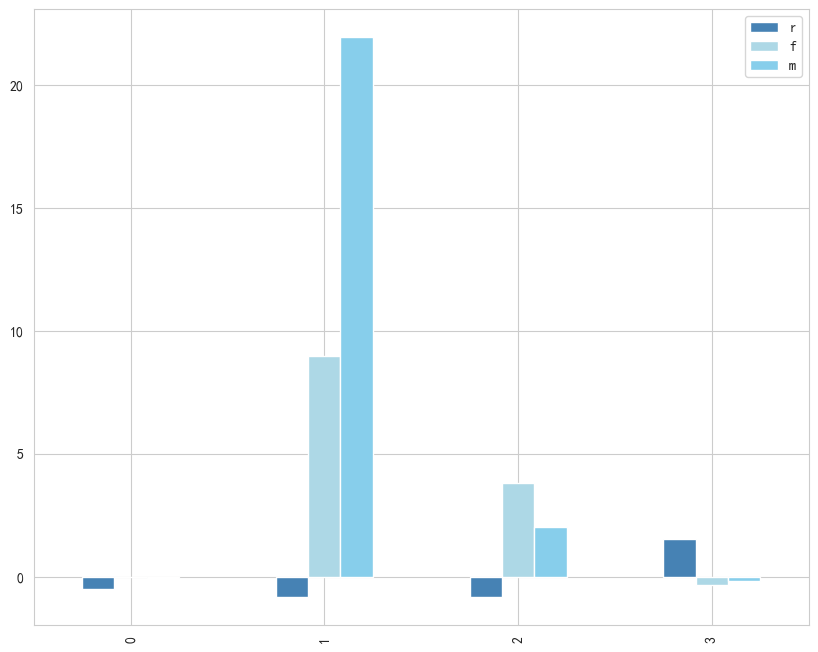

In [63]:
cluster_centers=kmeans.cluster_centers_
cluster_analysis= pd.DataFrame(data=cluster_centers,
                  columns = ['r','f','m']).reset_index(drop= True)
cluster_analysis.plot(kind='bar',color=['steelblue','lightblue',"skyblue"],clip_on=False)
plt.show()

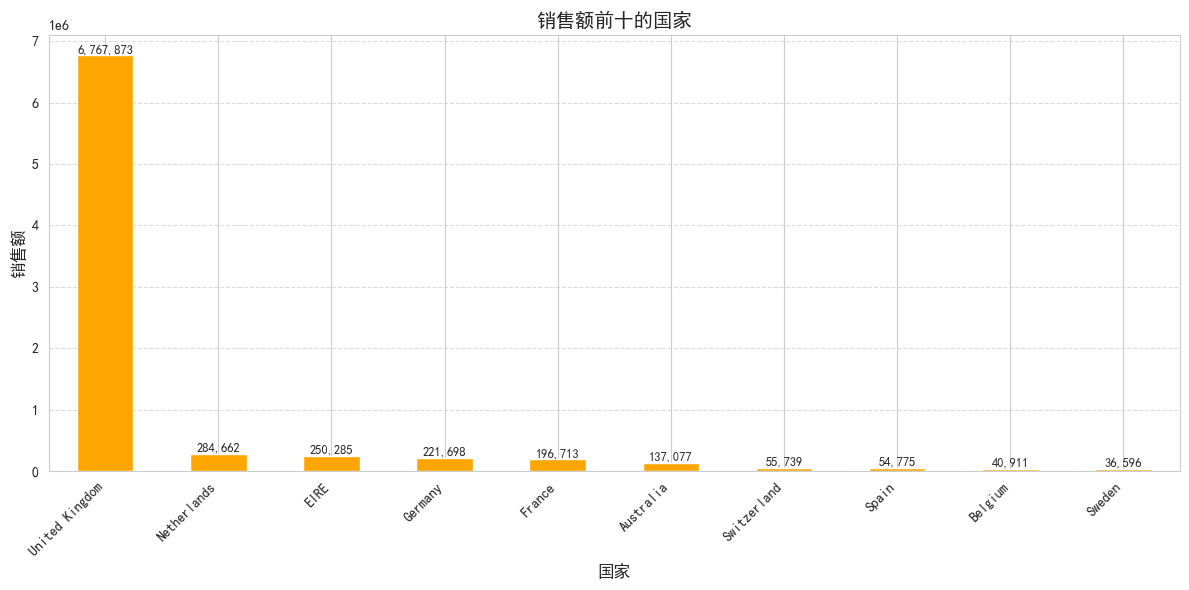

In [73]:
# 按国家分组计算总销售额
sales_by_country = dataset.groupby('Country')['Amount'].sum().sort_values(ascending=False)

# 获取销售额前十的国家
top10_countries = sales_by_country.head(10)

# 创建可视化
plt.figure(figsize=(12, 6))
top10_countries.plot(kind='bar', color='orange')

# 添加图表元素
plt.title('销售额前十的国家', fontsize=14)
plt.xlabel('国家', fontsize=12)
plt.ylabel('销售额', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示数值标签（仅限前十）
for i, v in enumerate(top10_countries):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


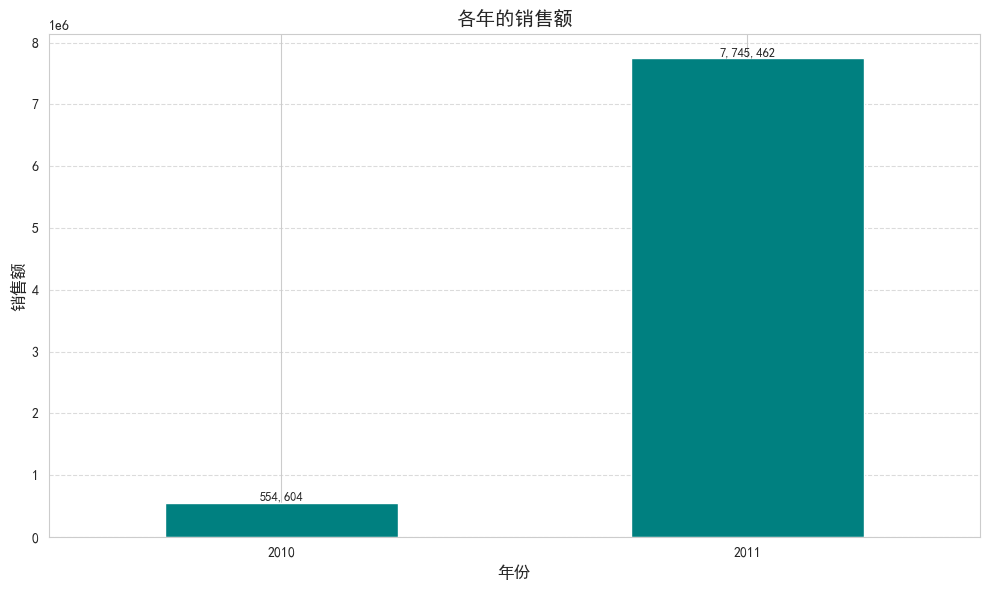

In [74]:
# 按年份分组计算总销售额
dataset['Year'] = pd.to_datetime(dataset['InvoiceDate']).dt.year
# 按年份分组计算总销售额
sales_by_year = dataset.groupby('Year')['Amount'].sum()

# 创建可视化
plt.figure(figsize=(10, 6))
sales_by_year.plot(kind='bar', color='teal')

# 添加图表元素
plt.title('各年的销售额', fontsize=14)
plt.xlabel('年份', fontsize=12)
plt.ylabel('销售额', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示数值标签
for i, v in enumerate(sales_by_year):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

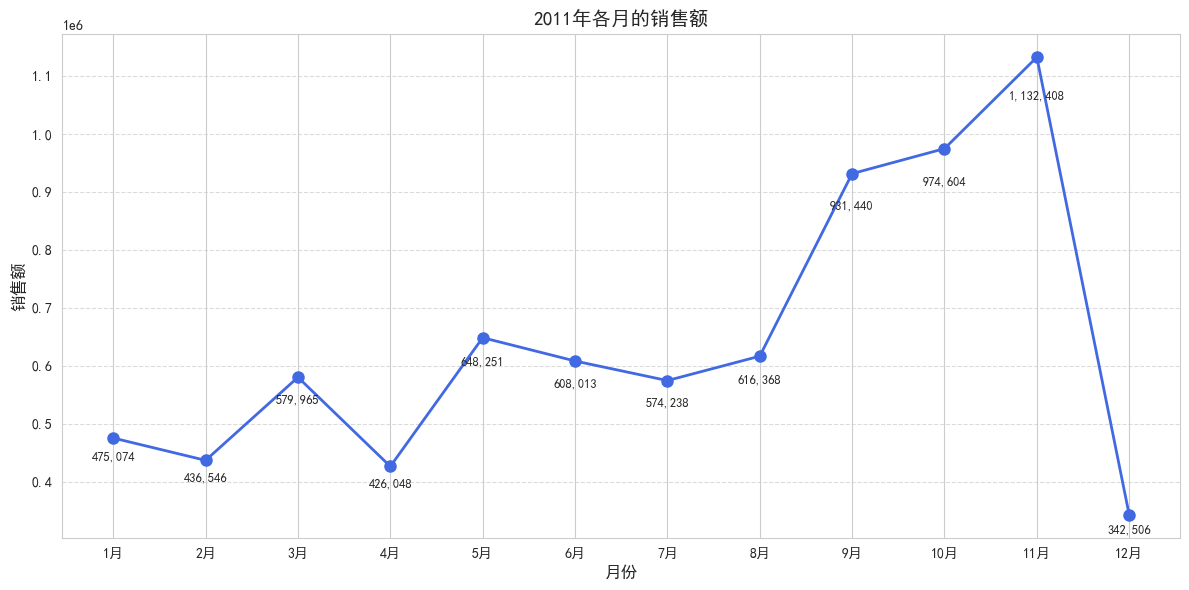

In [81]:
# 数据处理
dataset['Month'] = dataset['InvoiceDate'].dt.month
dataset_2011 = dataset[dataset['Year'] == 2011]
monthly_sales = dataset_2011.groupby('Month')['Amount'].sum()

# 创建折线图
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, 
         marker='o', color='royalblue', linewidth=2, markersize=8)

# 图表美化
plt.title('2011年各月的销售额', fontsize=14)
plt.xlabel('月份', fontsize=12)
plt.ylabel('销售额', fontsize=12)
plt.xticks(range(1,13), ['1月','2月','3月','4月','5月','6月',
                        '7月','8月','9月','10月','11月','12月'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加数值标签
for x, y in zip(monthly_sales.index, monthly_sales.values):
    plt.text(x, y*0.95, f'{y:,.0f}',  # 将y值减少5%作为偏移量
             ha='center', va='top', fontsize=9)  # 改为顶部对齐

plt.tight_layout()
plt.show()


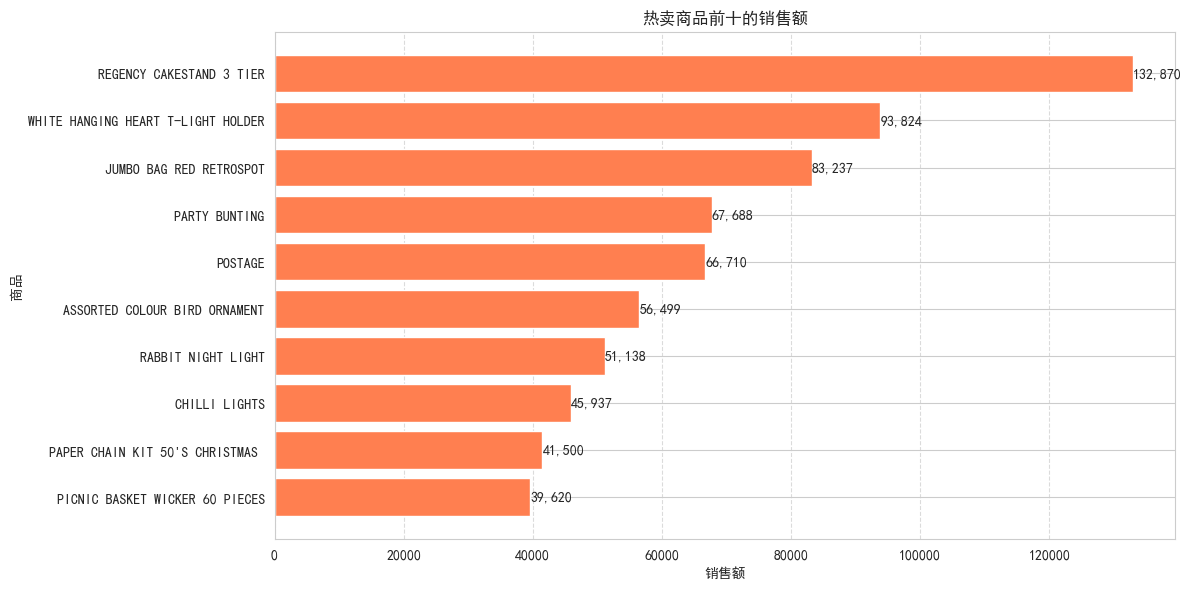

In [82]:
product_sales = dataset.groupby(['StockCode', 'Description'])['Amount'].sum().reset_index()
top10_products = product_sales.sort_values('Amount', ascending=False).head(10)

# 创建图表前先清除现有图形
plt.close('all') 

# 可视化部分
plt.figure(figsize=(12, 6))
plt.barh(top10_products['Description'], top10_products['Amount'], color='coral')
plt.title('热卖商品前十的销售额')
plt.xlabel('销售额')
plt.ylabel('商品')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(top10_products['Amount']):
    plt.text(v, i, f'{v:,.0f}', ha='left', va='center')

plt.tight_layout()
plt.show()